In [1]:
from fastai.metrics import error_rate
from fastai.vision import *
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd
import pokepy

# Loading information about the Pokémon

In [2]:
client = pokepy.V2Client(cache='in_disk', cache_location='/home/jupyter')
img_dir = '/home/jupyter/fastai-explorations/data/pokemon'
img_path = Path(img_dir)
fnames = os.listdir(img_path)

In [3]:
def process_image_fname(f):
    id = f[:-4]
    if '-' not in id:
        try:
            poke = client.get_pokemon(id)
            return (poke[0].name, [t.type.name for t in poke[0].types])
        except:
            pass
    return (None, None)

In [4]:
df = [process_image_fname(f) for f in tqdm(fnames)]
df = pd.DataFrame(df, columns=['name', 'types'])

df['fname'] = fnames
df['id'] = [f[:-4] for f in fnames]
pd.to_numeric(df['id'], errors='coerce')
df.sort_values('id', inplace=True)
df.reset_index(inplace=True)

df['primary_type'] = df.types.map(lambda x: x[0] if x is not None else None)

100%|██████████| 820/820 [00:04<00:00, 175.20it/s]


# Loading image data

In [5]:
data = ImageDataBunch.from_df(
    img_path,
    df[~df.isnull().any(axis=1)],
    fn_col='fname', label_col='types', ds_tfms=get_transforms(), size=224)

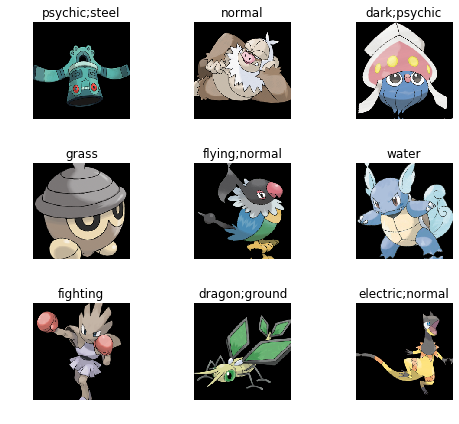

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'flying', 'ghost', 'grass', 'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water']


(18, 18)

# Training resnet34

In [8]:
def fixed_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1).long()
    return (input==targs).float().mean()

In [9]:
THRESHOLD = 0.1

In [10]:
acc_02 = partial(accuracy_thresh, thresh=THRESHOLD)
f_score = partial(fbeta, thresh=THRESHOLD)

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score])

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.825414,0.677247,0.084921,0.306638,00:05
1,0.772991,0.635546,0.086508,0.309800,00:04
2,0.713686,0.557060,0.092063,0.311095,00:04
3,0.668365,0.533150,0.091270,0.310940,00:04


In [13]:
learn.save('stage-1')

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

In [15]:
losses, idxs = interp.top_losses()

In [16]:
len(data.valid_ds) == len(losses)

False

In [17]:
len(losses) == len(idxs)

True

In [18]:
data.valid_ds

LabelList (140 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
dark;rock,normal,dark,fighting;bug,steel;bug
Path: /home/jupyter/fastai-explorations/data/pokemon

In [19]:
len(losses), len(idxs)

(2520, 2520)

In [20]:
# doc(interp.plot_multi_top_losses)

96 misclassified samples over 140 samples in the validation set.


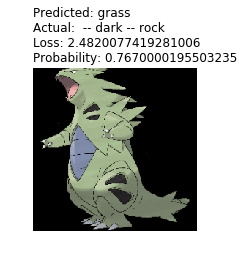

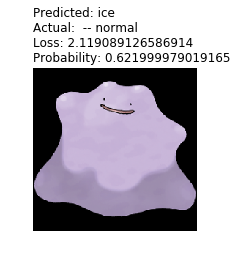

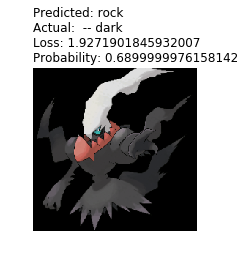

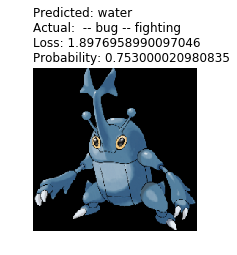

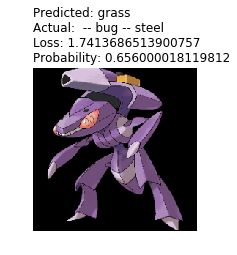

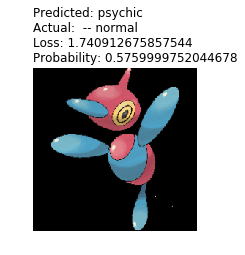

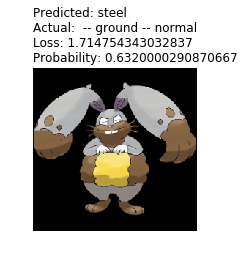

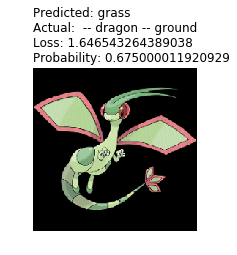

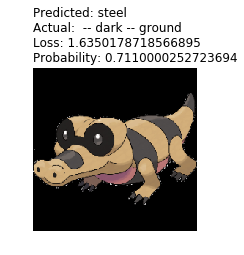

In [21]:
# interp.plot_top_losses(9, figsize=(15,11))
interp.plot_multi_top_losses(9, figsize=(3, 3))

In [22]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
# interp.most_confused(min_val=2)

# Unfreezing and fine-tuning learning rates

Because hand-drawn Pokémon cartoons are probably very different than what `resnet` was trained on, we should expect to use a relatively high learning rate to improve the results of our neural network.

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


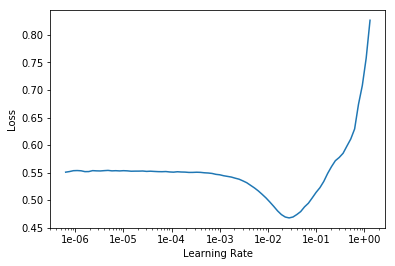

In [25]:
learn.recorder.plot()

In [26]:
learn.load('stage-1');

In [27]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.543536,0.487254,0.094841,0.311676,00:05
1,0.498191,0.363378,0.147619,0.321429,00:05
2,0.412232,0.260284,0.772619,0.394847,00:05
3,0.344736,0.273289,0.859524,0.402599,00:05
4,0.296128,0.269521,0.807540,0.461165,00:05
5,0.256345,0.273355,0.827381,0.456142,00:05
6,0.223191,0.269710,0.848810,0.450743,00:05
7,0.194166,0.268829,0.848016,0.477563,00:05
8,0.170044,0.271834,0.862302,0.476736,00:05
9,0.148671,0.282493,0.873413,0.464629,00:05


In [28]:
learn.save('stage-2')

72 misclassified samples over 140 samples in the validation set.


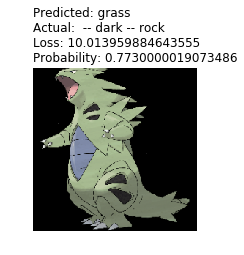

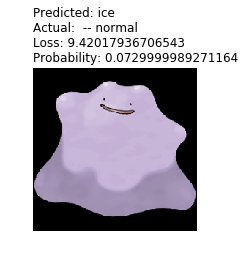

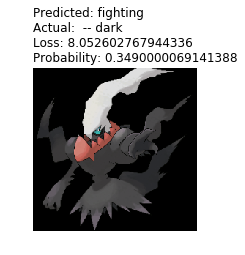

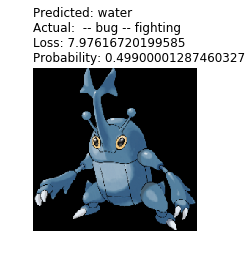

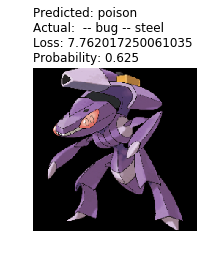

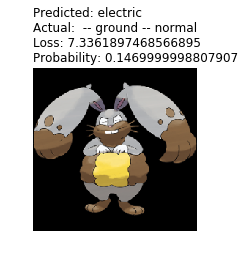

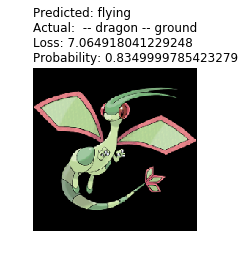

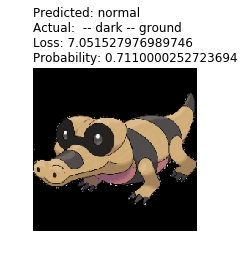

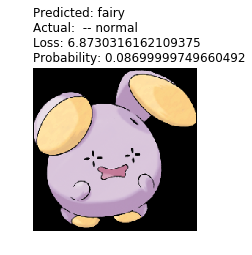

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_multi_top_losses(9, figsize=(3, 3))

# Training resnet50

In [30]:
learn50 = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score])

In [31]:
learn50.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.828648,0.806987,0.084524,0.309316,00:10
1,0.788809,0.678933,0.087302,0.309987,00:07
2,0.739562,0.592519,0.098413,0.312755,00:07
3,0.667365,0.447704,0.124206,0.313873,00:07
4,0.583591,0.338426,0.205159,0.325949,00:07
5,0.507353,0.286394,0.379762,0.369330,00:07
6,0.446152,0.271258,0.475000,0.391859,00:07
7,0.399933,0.269380,0.494444,0.391849,00:07


80 misclassified samples over 140 samples in the validation set.


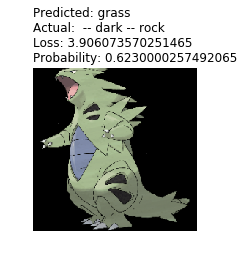

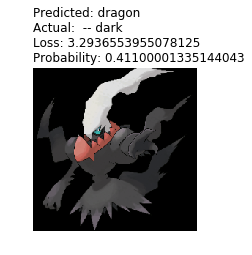

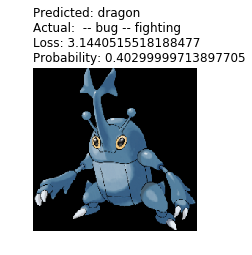

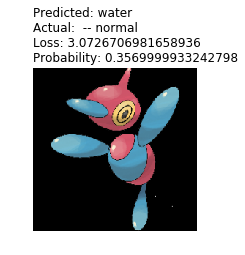

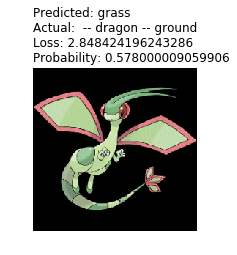

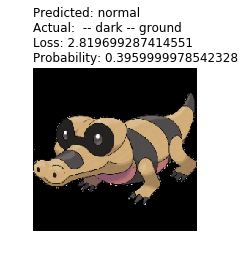

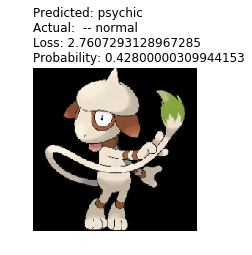

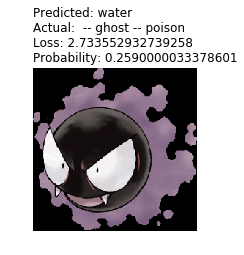

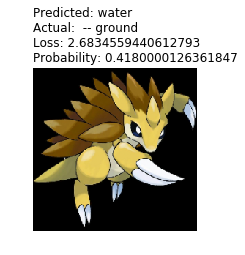

In [32]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_multi_top_losses(9, figsize=(3, 3))

In [33]:
learn50.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


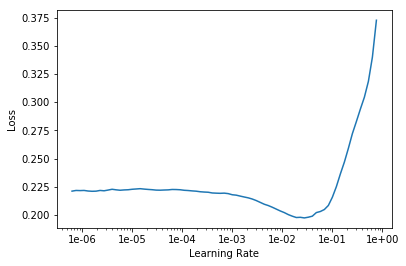

In [34]:
learn50.lr_find()
learn50.recorder.plot()

In [41]:
learn50.load('stage-1')
learn50.unfreeze()
learn50.fit_one_cycle(8, max_lr=slice(1e-6,5e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.217092,0.284930,0.807937,0.409587,00:08
1,0.215346,0.436941,0.790476,0.415418,00:08
2,0.201275,0.394484,0.847222,0.392162,00:08
3,0.184098,0.442438,0.876190,0.382794,00:08
4,0.164127,0.374393,0.875397,0.421114,00:08
5,0.144324,0.347414,0.891667,0.406700,00:08
6,0.125586,0.337547,0.893651,0.437540,00:08
7,0.110885,0.327699,0.891667,0.439160,00:08


73 misclassified samples over 140 samples in the validation set.


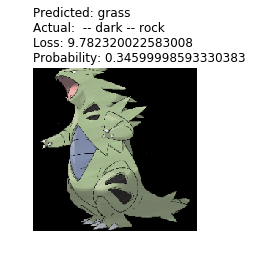

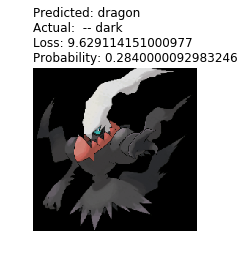

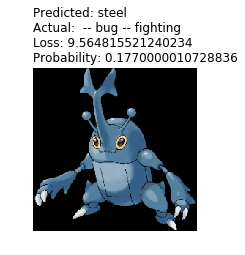

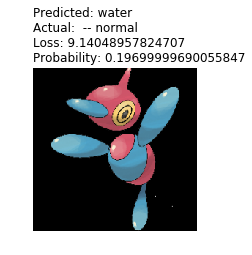

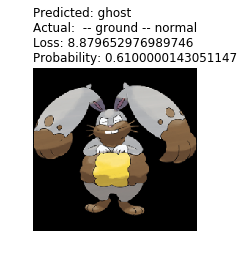

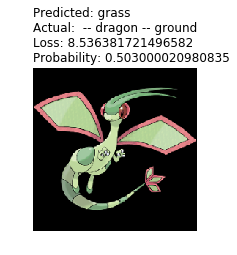

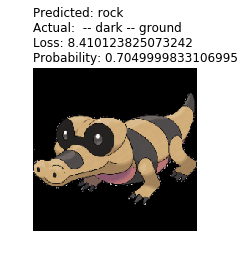

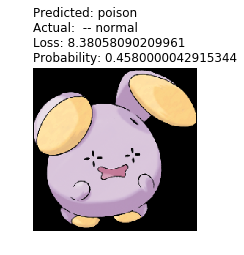

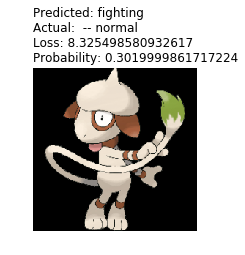

In [42]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_multi_top_losses(9, figsize=(3, 3))

In [43]:
learn50.save('stage-2')

# Visualizing items predicted correctly
...just to convince myself that this classifier is actually working.

In [44]:
def plot_multi_correct(self, samples:int=3, figsize:Tuple[int,int]=(8,8), save_misclassified:bool=False):
    "Show correct predictions along with their loss and probability of predicted class in a multilabeled dataset."
    if samples >20:
        print("Max 20 samples")
        return
    losses, idxs = self.top_losses(self.data.c)
    l_dim = len(losses.size())
    if l_dim == 1: losses, idxs = self.top_losses()
    infolist, ordlosses_idxs, mismatches_idxs, mismatches, losses_mismatches, mismatchescontainer = [],[],[],[],[],[]
    truthlabels = np.asarray(self.y_true, dtype=int)
    classes_ids = [k for k in enumerate(self.data.classes)]
    predclass = np.asarray(self.pred_class)
    for i,pred in enumerate(predclass):
        where_truth = np.nonzero((truthlabels[i]>0))[0]
        mismatch = np.all(pred==where_truth)
        if mismatch:
            mismatches_idxs.append(i)
            if l_dim > 1 : losses_mismatches.append((losses[i][pred], i))
            else: losses_mismatches.append((losses[i], i))
        if l_dim > 1: infotup = (i, pred, where_truth, losses[i][pred], np.round(self.probs[i], decimals=3)[pred], mismatch)
        else: infotup = (i, pred, where_truth, losses[i], np.round(self.probs[i], decimals=3)[pred], mismatch)
        infolist.append(infotup)
    ds = self.data.dl(self.ds_type).dataset
    mismatches = ds[mismatches_idxs]
    ordlosses = sorted(losses_mismatches, key = lambda x: x[0], reverse=False) # Controls the order of losses
    for w in ordlosses: ordlosses_idxs.append(w[1])
    mismatches_ordered_byloss = ds[ordlosses_idxs]
    print(f'{str(len(mismatches))} correctly classified samples over {str(len(self.data.valid_ds))} samples in the validation set.')
    for ima in range(len(mismatches_ordered_byloss)):
        mismatchescontainer.append(mismatches_ordered_byloss[ima][0])
    for sampleN in range(samples):
        actualclasses = ''
        for clas in infolist[ordlosses_idxs[sampleN]][2]:
            actualclasses = f'{actualclasses} -- {str(classes_ids[clas][1])}'
        imag = mismatches_ordered_byloss[sampleN][0]
        imag = show_image(imag, figsize=figsize)
        imag.set_title(f"""Predicted: {classes_ids[infolist[ordlosses_idxs[sampleN]][1]][1]} \nActual: {actualclasses}\nLoss: {infolist[ordlosses_idxs[sampleN]][3]}\nProbability: {infolist[ordlosses_idxs[sampleN]][4]}""",
                        loc='left')
        plt.show()
        if save_misclassified: return mismatchescontainer

28 correctly classified samples over 140 samples in the validation set.


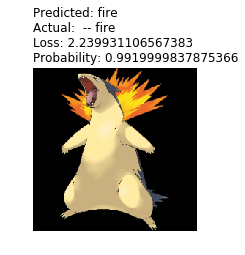

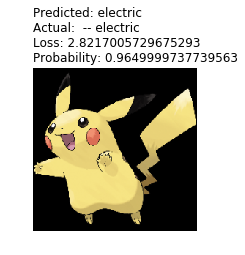

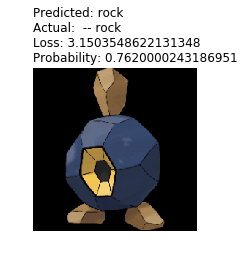

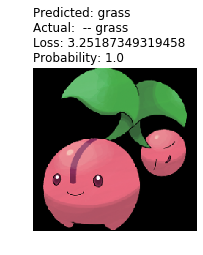

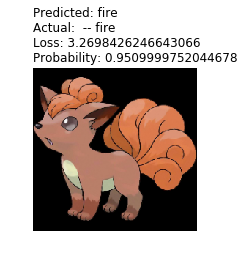

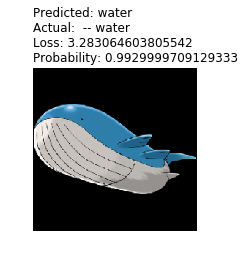

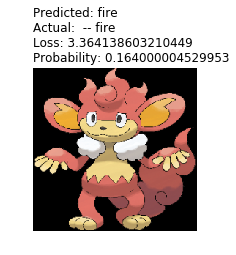

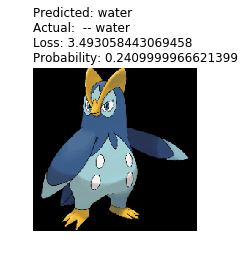

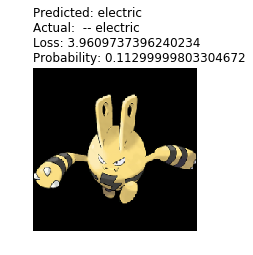

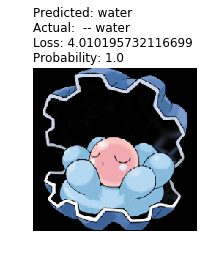

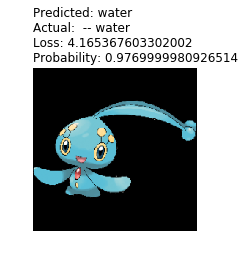

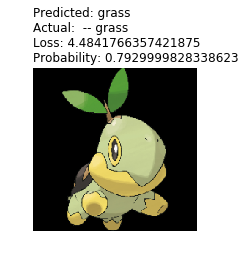

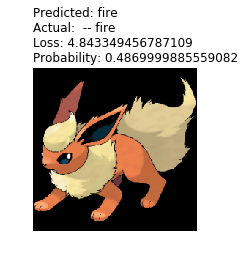

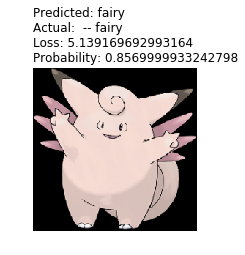

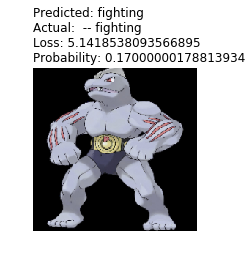

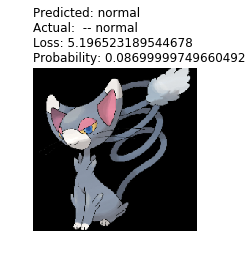

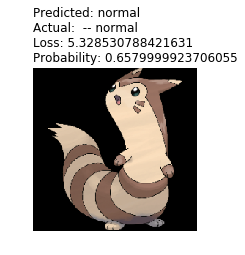

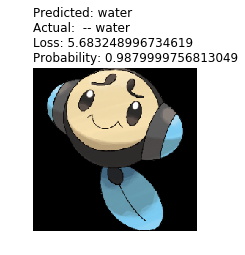

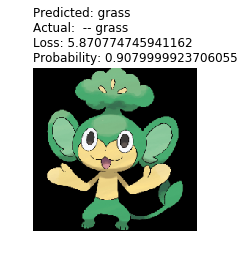

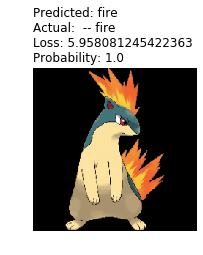

In [45]:
plot_multi_correct(interp50, 20, figsize=(3, 3))

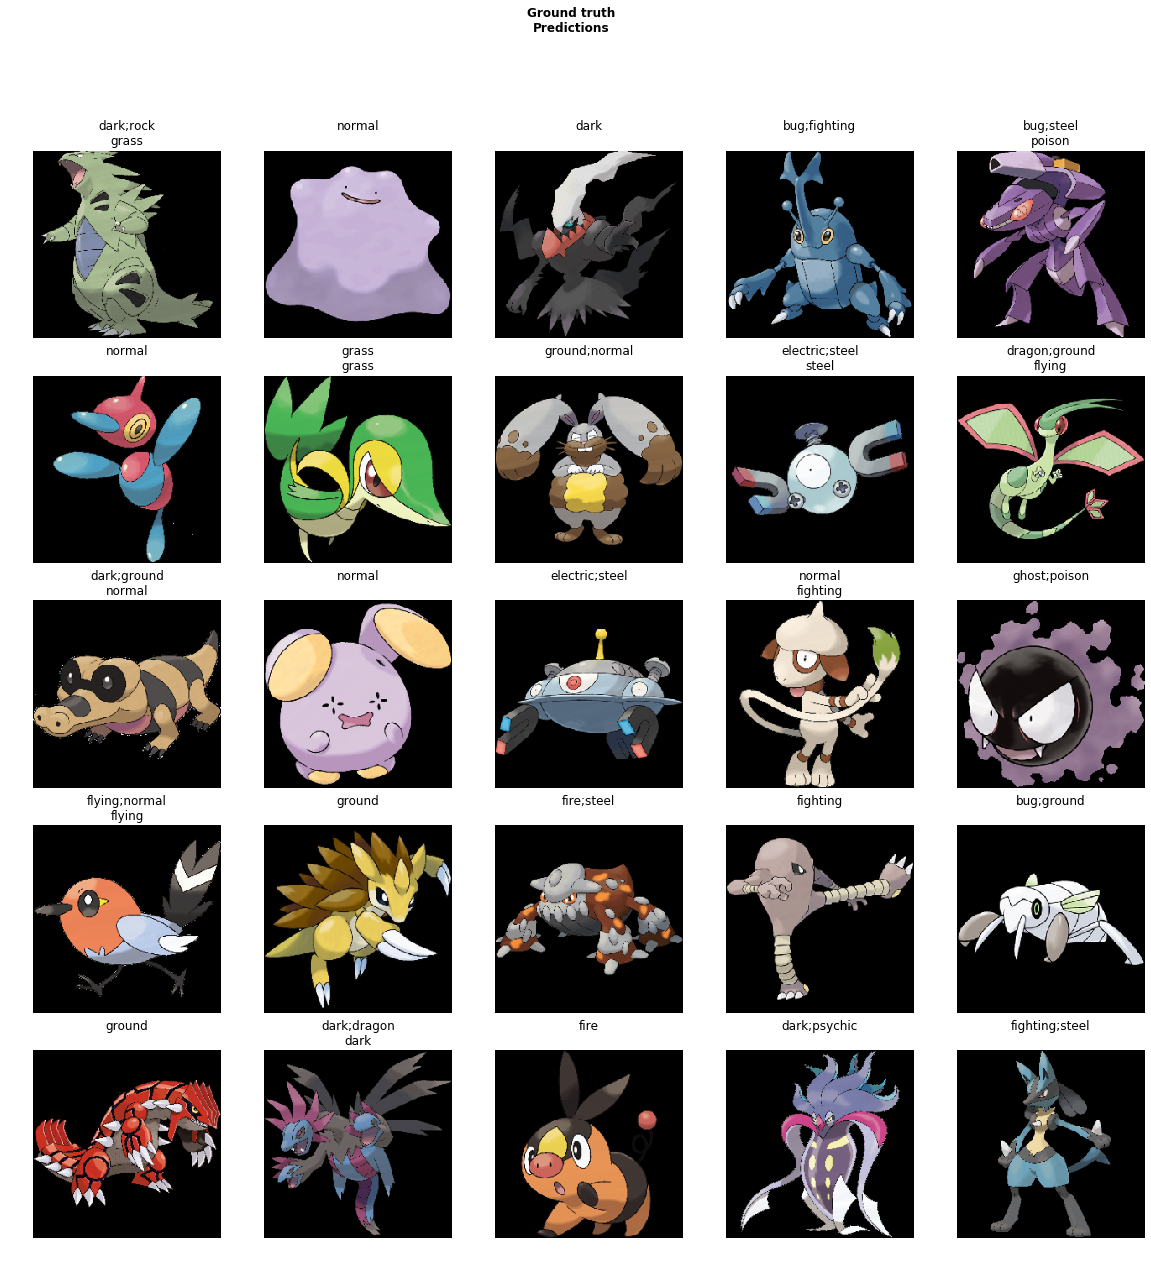

In [46]:
learn.show_results()